In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color='#384152' # 실행창의 색깔
sns.set(rc={'axes.facecolor':color, 'figure.facecolor':color})

import logging
import os

import time
import datetime
import locale
import logging
import os
import platform

%mkdir stock_data

In [38]:
party_df = pd.read_csv('party_df.csv')
stock_code = {name : '{:06}'.format(code)
        for name, code in zip(party_df['종목명'], party_df['종목코드'])}

In [45]:
stock_code['한일시멘트'] = stock_code['한일홀딩스']
del stock_code['한일홀딩스']

In [91]:
raw_data['삼성전자'].reset_index().columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [96]:
import pickle
with open('raw_data_20190115.pickle', 'rb') as f:
    raw_data = pickle.load(f)
for stock_name, df in raw_data.items():
    data = df.reset_index()
    data.columns = ['date', 'open', 'high', 'low', 'close', 'adj close', 'volume']
    data.to_csv('./stock_data/{}.csv'.format(stock_code[stock_name]), index=False)

In [97]:
pd.Series(stock_code).to_csv('./stock_data/stock_name_code.csv')

In [2]:
def get_MACD(df, short_ma=12, long_ma=26, signal_period=9):
    ewm_12 = df['close'].ewm(span = short_ma, min_periods = short_ma - 1).mean()
    ewm_26 = df['close'].ewm(span = long_ma, min_periods = long_ma - 1).mean()
    df['MACD'] = ewm_12 - ewm_26
    df['MACDSignal'] = df['MACD'].ewm(span = signal_period, min_periods = signal_period-1).mean()
    df['MACDDiff'] = df['MACD'] - df['MACDSignal']
    return df

def get_Stochastic(df, n=14):
    df['sto_K_{}'.format(n)] = 100 * ((df.close - df.low.rolling(n).min()) / 
                                      (df.high.rolling(n).max() - df.low.rolling(n).min()))
    df['sto_D_{}'.format(n)] = df['sto_K_{}'.format(n)].rolling(3).mean()
    return df

def get_RSI(df, n=14):
    U = np.where(df['close'].diff(1)>0, df['close'].diff(1), 0)
    D = np.where(df['close'].diff(1)<0, df['close'].diff(1)*(-1), 0)

    AU = pd.Series(U).rolling(window=n, min_periods=n).mean()
    AD = pd.Series(D).rolling(window=n, min_periods=n).mean()

    RSI = AU.div(AD+AU) * 100
    df['RSI_{}'.format(n)] = RSI.values
    return df

def get_RoC(df, periods):
    df['roc_{}'.format(periods)] = df['close'].pct_change(periods=periods)
    return df

def get_CV(df, window):
    df['his_vol_{}'.format(window)] = np.log(df['close'] / df['close'].shift(1)).rolling(window).std()*(252**0.5)
    return df

def get_WilliamR(df, n):
    W_R = -100 * ((df.high.rolling(n).max() - df.close) / (df.high.rolling(n).max() - df.low.rolling(n).min()))
    df['WR_{}'.format(n)] = W_R
    return df

def get_CCI(df, window):
    TP = (df.close + df.low + df.high) / 3
    dataX = []
    for i in range(len(TP) - window+1):
        a = TP.values[i:(i+window)]
        dataX.append(a)
    dataMean = [i.mean() for i in dataX]
    AVEDEV = [abs(x - mean).mean() for x, mean 
              in zip(dataX, dataMean)]
    for i in range(window-1):
        AVEDEV.insert(0,np.nan)
    AVEDEV = pd.Series(AVEDEV, index = TP.index)
    CCI = (TP - TP.rolling(20).mean()) / (0.015 * AVEDEV)
    df['CCI_{}'.format(window)] = CCI
    return df

def get_DI(df, window):
    df['DI_{}'.format(window)] = 100 * ((df.close - df.close.rolling(window).mean()) / df.close.rolling(window).mean())
    return df

In [3]:
# data_manager.py

def load_chart_data(fpath):
    chart_data = pd.read_csv(fpath, thousands=',')
    return chart_data

def preprocess(chart_data, windows):
    prep_data = chart_data
    for window in windows:
        prep_data['close_ma{}'.format(window)] = prep_data['close'].rolling(window).mean()
        prep_data['volume_ma{}'.format(window)] = (
            prep_data['volume'].rolling(window).mean())
    return prep_data, len(prep_data.columns)

def build_training_data(prep_data):
    training_data = prep_data
    for window in range(12, 91):
        training_data = get_CV(training_data, window)
    for periods in range(1, 11):
        training_data = get_RoC(training_data, periods)
    for n in range(3, 91):
        training_data = get_RSI(training_data, n)
        training_data = get_Stochastic(training_data, n)
        training_data = get_WilliamR(training_data, n)
    training_data = get_CCI(training_data, 20)
    for window in [5,10]:
        training_data = get_DI(training_data, window)
    training_data = get_MACD(training_data)
    return training_data

def make_target(df, use_fn='f', period=1, window=1, 
                method='regress', thresh=.02):
    y_df = pd.DataFrame(index=df.index)
    f = lambda x, i : np.log(x.shift(-1 * i) / x)
    g = lambda x, i, j : np.log(x.shift(-1 * i) / x.rolling(j).mean())
    if window > 99:
        target = 'sh{:02}_Y_{:03}'.format(period, window)
    else:
        target = 'sh{:02}_Y_{:02}'.format(period, window)
    target = target[:6] if use_fn=='f' else target
    y_df[target] = \
            f(df['close'], period) if use_fn == 'f' else g(df['close'], period, window)
    if method != 'regress':
        y_df[target] = np.where(
            y_df[target] > thresh, 1, np.where(
                y_df[target] < (-1 * thresh), -1, 0))
    return y_df

In [4]:
def concat_x_y(df, period, window, n_col=0,
               use_fn='f', thresh=.02, method='regress'):
    y_df = make_target(df, use_fn=use_fn, period=period, window=window, 
                           thresh=thresh, method=method)
    y = y_df.columns[0]
    compact_df = pd.concat((df, y_df), axis=1)
#     compact_df = compact_df[compact_df.columns[n_col:]]
#     compact_df = compact_df.dropna()
    return compact_df, y

def train_test_split(compact_df, start, end):
    train = compact_df[(compact_df['date'] >= start) &
                   (compact_df['date'] <= end)]
    test = compact_df[compact_df['date'] >= \
                (pd.Timestamp(end) + pd.Timedelta('1 days')).strftime('%Y-%m-%d')]
    train, test = train.dropna(), test.dropna()
    return train, test

def correl_selection(df, y, corr_li):
    col_set = {}
    for col_name in corr_li:
        corr_ = abs(
            df[
                [col for col in df 
                 if (col.find(col_name) != -1)|(col.find(y) != -1)]
            ].corr()[y]
        ).sort_values(ascending=False)
        col_set[corr_.index[1]] = corr_.iloc[1]
    return col_set

In [5]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import sklearn.metrics as met
import time

In [10]:
stock_code = '005930'
chart_data = load_chart_data('./stock_data/{}.csv'.format(stock_code))
prepare_y_dict = {}

windows = [i for i in range(1, 90)]
prep_data, n_col = preprocess(chart_data, windows=windows)
training_data = build_training_data(prep_data)
del prep_data

thresh = .02
corr_li = ['sto_K','sto_D','RSI','roc','his_vol','WR',
                 'CCI','DI','MACD','MACDSignal','MACDDiff']
period = 80
pred_n = 'pred_{:02}'.format(period)
_prepare = {}
max_precision, max_prec_day = 0, 0
compact_df, comp_y = concat_x_y(training_data, period=period, window=1, 
                               n_col=n_col, use_fn='f', 
                               thresh=thresh, method='regress')
train, test = train_test_split(compact_df, start, end)
col_set = correl_selection(train, y=comp_y, corr_li=corr_li)
y_valid = np.where(train[comp_y].values > 0, 1, 0)
comp_y_tuple = (train, test, col_set)

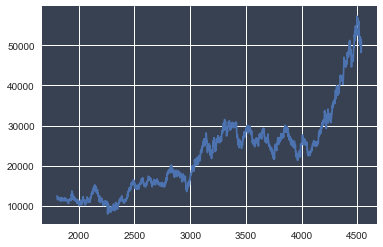

In [19]:
_chart_data = chart_data[(chart_data['date'] >= '2007-01-01') & (chart_data['date'] <= '2017-12-31')]
_chart_data['close'].plot()

In [26]:
compact_df[compact_df['date'] == '2013-01-02']

,date,open,high,low,close,adj close,volume,close_ma1,volume_ma1,close_ma2,...,sto_K_90,sto_D_90,WR_90,CCI_20,DI_5,DI_10,MACD,MACDSignal,MACDDiff,sh80_Y
3309,2013-01-02,30660.0,31520.0,30540.0,31520.0,42.188969,11449650,31520.0,11449650.0,30980.0,...,100.0,95.041322,-0.0,178.538813,4.537012,4.954715,674.790614,646.211492,28.579122,-0.058802


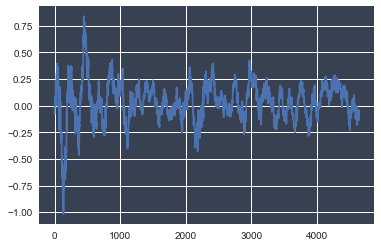

In [15]:
compact_df[compact_df.columns[-1]].plot()

In [21]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')


def calc_mdd(list_x, list_pv):
    """
    MDD(Maximum Draw-Down) 계산
    :param list_pv: 포트폴리오 가치 리스트
    :return:
    """
    list_x = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in list_x]
    arr_pv = np.array(list_pv)
    peak_lower = np.argmax(np.maximum.accumulate(arr_pv) - arr_pv)
    peak_upper = np.argmax(arr_pv[:peak_lower])
    
    idx_min = np.argmin(arr_pv)
    idx_max = np.argmax(arr_pv)

    # ------------------------------
    fig, ax = plt.subplots()
    ax.plot(list_x, arr_pv)
#     ax.plot([list_x[peak_upper]], [arr_pv[peak_upper]], '>', color='red')
#     ax.plot([list_x[peak_lower]], [arr_pv[peak_lower]], '<', color='blue')
    ax.plot([list_x[peak_upper], list_x[peak_lower]], [arr_pv[peak_upper], arr_pv[peak_lower]], '-', color='blue')
    ax.plot([list_x[idx_min]], [arr_pv[idx_min]], 'v', color='blue')
    ax.plot([list_x[idx_max]], [arr_pv[idx_max]], '^', color='red')
    
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)  
    
    plt.show()
    # ------------------------------

    return (arr_pv[peak_lower] - arr_pv[peak_upper]) / arr_pv[peak_upper]


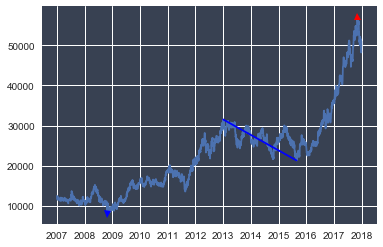

-0.3229695431472081


In [22]:
print(calc_mdd(_chart_data['date'], _chart_data['close']))

In [13]:
compact_df.tail()

,date,open,high,low,close,adj close,volume,close_ma1,volume_ma1,close_ma2,...,sto_K_90,sto_D_90,WR_90,CCI_20,DI_5,DI_10,MACD,MACDSignal,MACDDiff,sh80_Y
4715,2018-09-20,46850.0,47600.0,46400.0,47250.0,46897.121094,13536966,47250.0,13536966.0,46700.0,...,39.473684,29.473684,-60.526316,71.258907,2.762070,4.086353,-71.828002,-160.811930,88.983927,NaN
4716,2018-09-21,46550.0,47550.0,46550.0,47400.0,47046.000000,14476906,47400.0,14476906.0,47325.0,...,41.052632,36.140351,-58.947368,69.677808,2.397926,3.844890,54.663753,-117.716793,172.380546,NaN
4717,2018-09-27,46950.0,47500.0,46450.0,47500.0,47500.000000,15804586,47500.0,15804586.0,47450.0,...,42.105263,40.877193,-57.894737,62.410124,1.582549,3.609990,161.121239,-61.949187,223.070426,NaN
4718,2018-09-28,47250.0,47250.0,46300.0,46450.0,46450.000000,11270515,46450.0,11270515.0,46975.0,...,31.052632,38.070175,-68.947368,28.718831,-1.064963,1.011199,158.931278,-17.773094,176.704372,NaN
4719,2018-10-01,46450.0,46800.0,45800.0,46350.0,46350.000000,6354983,46350.0,6354983.0,46400.0,...,30.000000,34.385965,-70.000000,5.954466,-1.361992,0.400736,147.427107,15.266946,132.160160,NaN


In [18]:
# main.py
start_time, check_point = time.time(), 0
print('#1 Generate Feature & Target and Correlation Selection\n')
print('#2 Max Precision Filter')
print(' - 각 예측 기간별 Time window에 대하여 Max Precision을 측정 및 선별)\n')

stock_code = '005930'
chart_data = load_chart_data('./stock_data/{}.csv'.format(stock_code))
prepare_y_dict = {}

windows = [i for i in range(1, 90)]
prep_data, n_col = preprocess(chart_data, windows=windows)
training_data = build_training_data(prep_data)
del prep_data

thresh = .02 # Use only method=='Classification'
periods = [i for i in range(1, 91)]
windows = [i for i in range(1, 91, 3)]
# periods = [1, 5, 10, 20, 60]
# windows = [1, 5, 10, 20, 60]
corr_li = ['sto_K','sto_D','RSI','roc','his_vol','WR',
                 'CCI','DI','MACD','MACDSignal','MACDDiff']
start, end = '2007-01-01', '2017-12-31' # 훈련시킬 기간
for period in periods:
    pred_n = 'pred_{:02}'.format(period)
    print(pred_n + ' : (max precision 갱신 시 message 출력)')
    _prepare = {}
    max_precision, max_prec_day = 0, 0
    compact_df, comp_y = concat_x_y(training_data, period=period, window=1, 
                               n_col=n_col, use_fn='f', 
                               thresh=thresh, method='regress')
    train, test = train_test_split(compact_df, start, end)
    col_set = correl_selection(train, y=comp_y, corr_li=corr_li)
    y_valid = np.where(train[comp_y].values > 0, 1, 0)
    comp_y_tuple = (train, test, col_set)
    for window in windows:
        compact_df, y = concat_x_y(training_data, period=period, window=window, 
                                   n_col=n_col, use_fn='g', 
                                   thresh=thresh, method='regress')
        train, test = train_test_split(compact_df, start, end)
        col_set = correl_selection(train, y=y, corr_li=corr_li)
        n_cv = 5
        ix_cv = int(len(train) / n_cv)
        precision = 0
        for i in [0,1,2,3]:
            X_train = train[list(col_set.keys())].iloc[i*ix_cv:(i+1)*ix_cv]
            y_train = train[y].iloc[i*ix_cv:(i+1)*ix_cv]
            X_valid = train[list(col_set.keys())].iloc[(i+1)*ix_cv:(i+2)*ix_cv]
            y_true = y_valid[(i+1)*ix_cv:(i+2)*ix_cv]

            xgb_reg = xgb.XGBRegressor(
                 learning_rate =0.15,
                 n_estimators=100,
                 max_depth=5,
                 min_child_weight=2,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 nthread=4,
                 scale_pos_weight=1,
                 seed=27,
                 eval_metric='map')
            xgb_reg.fit(X_train, y_train)
        
            y_pred = np.where(xgb_reg.predict(X_valid) > 0, 1, 0)
            precision += met.precision_score(y_true, y_pred)
        precision = precision / (n_cv - 1)
        if precision > max_precision:
            max_prec_day = y[-2:]
            max_precision = precision
            tot_time = time.time() - start_time
            print('\t{} : {:.2%}\telapse:{:.2f} sec, TOT:{:.2f} min'.format(
                y, max_precision, tot_time-check_point, tot_time / 60))
            check_point = tot_time
        _prepare[y] = (train, test, col_set)
    print('\tmax_precision_day : {}\n\tmax_precision : {:.2%}'.format(max_prec_day, max_precision))
    train, test, col_set = _prepare[y[:-2]+max_prec_day]
    prepare_y_dict[pred_n] = {comp_y : comp_y_tuple,
                              y : (train, test, col_set, max_prec_day, max_precision)}
    tot_time = time.time() - start_time
    print("\tDone '" + pred_n + "'\t\telapse:{:.2f} sec, TOT:{:.2f} min".format(
                tot_time - check_point, tot_time / 60))
    check_point = tot_time
    
features_chart_data = ['date', 'open', 'high', 'low', 'close', 'volume']
chart_data = training_data[features_chart_data]

#1 Generate Feature & Target and Correlation Selection

#2 Max Precision Filter
 - 각 예측 기간별 Time window에 대하여 Max Precision을 측정 및 선별)

pred_01 : (max precision 갱신 시 message 출력)
	sh01_Y_01 : 52.91%	elapse:3.27 sec, TOT:0.05 min
	max_precision_day : 01
	max_precision : 52.91%
	Done 'pred_01'		elapse:29.88 sec, TOT:0.55 min
pred_02 : (max precision 갱신 시 message 출력)
	sh02_Y_01 : 55.44%	elapse:1.54 sec, TOT:0.58 min
	max_precision_day : 01
	max_precision : 55.44%
	Done 'pred_02'		elapse:31.19 sec, TOT:1.10 min
pred_03 : (max precision 갱신 시 message 출력)
	sh03_Y_01 : 55.81%	elapse:1.42 sec, TOT:1.12 min
	max_precision_day : 01
	max_precision : 55.81%
	Done 'pred_03'		elapse:42.51 sec, TOT:1.83 min
pred_04 : (max precision 갱신 시 message 출력)
	sh04_Y_01 : 56.20%	elapse:1.67 sec, TOT:1.86 min
	max_precision_day : 01
	max_precision : 56.20%
	Done 'pred_04'		elapse:31.30 sec, TOT:2.38 min
pred_05 : (max precision 갱신 시 message 출력)
	sh05_Y_01 : 53.62%	elapse:1.58 sec, TOT:2.41 min
	sh05_Y_04 : 54.19%	el

	sh27_Y_01 : 61.44%	elapse:1.46 sec, TOT:14.92 min
	sh27_Y_07 : 63.93%	elapse:2.13 sec, TOT:14.96 min
	sh27_Y_19 : 64.91%	elapse:4.27 sec, TOT:15.03 min
	sh27_Y_25 : 65.28%	elapse:2.17 sec, TOT:15.06 min
	sh27_Y_28 : 66.15%	elapse:1.09 sec, TOT:15.08 min
	max_precision_day : 28
	max_precision : 66.15%
	Done 'pred_27'		elapse:22.27 sec, TOT:15.45 min
pred_28 : (max precision 갱신 시 message 출력)
	sh28_Y_01 : 56.75%	elapse:1.67 sec, TOT:15.48 min
	sh28_Y_04 : 62.57%	elapse:1.19 sec, TOT:15.50 min
	sh28_Y_16 : 63.35%	elapse:4.50 sec, TOT:15.58 min
	sh28_Y_19 : 64.54%	elapse:1.22 sec, TOT:15.60 min
	sh28_Y_22 : 64.55%	elapse:1.14 sec, TOT:15.62 min
	sh28_Y_25 : 66.80%	elapse:1.22 sec, TOT:15.64 min
	max_precision_day : 25
	max_precision : 66.80%
	Done 'pred_28'		elapse:23.32 sec, TOT:16.02 min
pred_29 : (max precision 갱신 시 message 출력)
	sh29_Y_01 : 58.46%	elapse:1.48 sec, TOT:16.05 min
	sh29_Y_04 : 59.75%	elapse:1.10 sec, TOT:16.07 min
	sh29_Y_16 : 65.89%	elapse:4.24 sec, TOT:16.14 min
	sh29_Y_

	sh53_Y_25 : 76.86%	elapse:5.54 sec, TOT:30.14 min
	max_precision_day : 25
	max_precision : 76.86%
	Done 'pred_53'		elapse:24.13 sec, TOT:30.54 min
pred_54 : (max precision 갱신 시 message 출력)
	sh54_Y_01 : 75.26%	elapse:1.64 sec, TOT:30.57 min
	sh54_Y_04 : 75.47%	elapse:1.14 sec, TOT:30.59 min
	sh54_Y_07 : 75.66%	elapse:1.12 sec, TOT:30.61 min
	sh54_Y_19 : 75.88%	elapse:4.51 sec, TOT:30.68 min
	sh54_Y_22 : 76.42%	elapse:1.15 sec, TOT:30.70 min
	sh54_Y_25 : 77.69%	elapse:1.09 sec, TOT:30.72 min
	max_precision_day : 25
	max_precision : 77.69%
	Done 'pred_54'		elapse:23.94 sec, TOT:31.12 min
pred_55 : (max precision 갱신 시 message 출력)
	sh55_Y_01 : 74.73%	elapse:1.53 sec, TOT:31.15 min
	sh55_Y_04 : 75.11%	elapse:1.12 sec, TOT:31.16 min
	sh55_Y_10 : 76.26%	elapse:2.21 sec, TOT:31.20 min
	sh55_Y_19 : 76.45%	elapse:3.29 sec, TOT:31.26 min
	sh55_Y_22 : 77.24%	elapse:1.11 sec, TOT:31.27 min
	sh55_Y_25 : 77.64%	elapse:1.11 sec, TOT:31.29 min
	max_precision_day : 25
	max_precision : 77.64%
	Done 'pred

	sh76_Y_19 : 78.53%	elapse:2.99 sec, TOT:43.32 min
	sh76_Y_22 : 78.92%	elapse:1.01 sec, TOT:43.33 min
	sh76_Y_25 : 79.21%	elapse:1.00 sec, TOT:43.35 min
	max_precision_day : 25
	max_precision : 79.21%
	Done 'pred_76'		elapse:21.20 sec, TOT:43.70 min
pred_77 : (max precision 갱신 시 message 출력)
	sh77_Y_01 : 76.65%	elapse:1.36 sec, TOT:43.73 min
	sh77_Y_07 : 77.06%	elapse:1.99 sec, TOT:43.76 min
	sh77_Y_13 : 77.34%	elapse:2.01 sec, TOT:43.79 min
	sh77_Y_16 : 77.55%	elapse:1.00 sec, TOT:43.81 min
	sh77_Y_19 : 77.88%	elapse:1.01 sec, TOT:43.83 min
	sh77_Y_22 : 79.01%	elapse:1.00 sec, TOT:43.84 min
	max_precision_day : 22
	max_precision : 79.01%
	Done 'pred_77'		elapse:22.94 sec, TOT:44.23 min
pred_78 : (max precision 갱신 시 message 출력)
	sh78_Y_01 : 76.57%	elapse:1.36 sec, TOT:44.25 min
	sh78_Y_07 : 78.11%	elapse:2.00 sec, TOT:44.28 min
	sh78_Y_16 : 78.31%	elapse:3.01 sec, TOT:44.33 min
	sh78_Y_25 : 79.96%	elapse:3.02 sec, TOT:44.38 min
	max_precision_day : 25
	max_precision : 79.96%
	Done 'pred

In [ ]:
d = chart_data[(chart_data['date'] >= '2007-01-01') & (chart_data['date'] <= '2017-12-31')]
plt.plot(d.date, d.close)

In [19]:
# main.py
print('#1 Generate Feature & Target and Correlation Selection\n')
start_time, check_point = time.time(), 0
stock_code = '005930'
chart_data = load_chart_data('./stock_data/{}.csv'.format(stock_code))
prepare_y_dict = {}

windows = [i for i in range(1, 90)]
prep_data, n_col = preprocess(chart_data, windows=windows)
training_data = build_training_data(prep_data)
del prep_data

thresh = .02 # Use only method=='Classification'
periods = [i for i in range(1, 90, 3)]
windows = [i for i in range(1, 90, 3)]
corr_li = ['sto_K','sto_D','RSI','roc','his_vol','WR',
                 'CCI','DI','MACD','MACDSignal','MACDDiff']
start, end = '2007-01-01', '2017-12-31' # 훈련시킬 기간
for period in periods:
    elapse = semi_start_time - start_time
    _prepare = {}
    compact_df, y = concat_x_y(training_data, period=period, window=1, 
                               n_col=n_col, use_fn='f', 
                               thresh=thresh, method='regress')
    train, test = train_test_split(compact_df, start, end)
    col_set = correl_selection(train, y=y, corr_li=corr_li)
    _prepare[y] = (train, test, col_set)
    for window in windows:
        compact_df, y = concat_x_y(training_data, period=period, window=window, 
                                   n_col=n_col, use_fn='g', 
                                   thresh=thresh, method='regress')
        train, test = train_test_split(compact_df, start, end)
        col_set = correl_selection(train, y=y, corr_li=corr_li)
        _prepare[y] = (train, test, col_set)
    if period % 5 == 0:
        tot_time = time.time() - start_time
        print('  Done pred_{:02} elapse:{:.2f}sec, TOT:{:.2f}min'.format(
            period, tot_time - check_point, tot_time / 60))
        check_point = tot_time
    prepare_y_dict['pred_{:02}'.format(period)] = _prepare
    
features_chart_data = ['date', 'open', 'high', 'low', 'close', 'volume']
chart_data = training_data[features_chart_data]
print("\nTOTAL Done {:.2f} min".format((time.time() - start_time) / 60))

#1 Generate Feature & Target and Correlation Selection

  Done pred_05 63.29 sec TOT : 63.29 sec
  Done pred_10 68.45 sec TOT : 131.74 sec
  Done pred_15 67.55 sec TOT : 199.29 sec
  Done pred_20 61.91 sec TOT : 261.20 sec
  Done pred_25 65.93 sec TOT : 327.13 sec
  Done pred_30 73.37 sec TOT : 400.50 sec
  Done pred_35 67.39 sec TOT : 467.89 sec
  Done pred_40 63.14 sec TOT : 531.03 sec
  Done pred_45 74.90 sec TOT : 605.93 sec
  Done pred_50 73.61 sec TOT : 679.54 sec
  Done pred_55 70.80 sec TOT : 750.35 sec
  Done pred_60 70.74 sec TOT : 821.09 sec
  Done pred_65 75.44 sec TOT : 896.53 sec
  Done pred_70 72.32 sec TOT : 968.84 sec
  Done pred_75 79.31 sec TOT : 1048.16 sec
  Done pred_80 75.98 sec TOT : 1124.14 sec
  Done pred_85 106.83 sec TOT : 1230.97 sec

TOTAL Done 21.56 min


In [29]:
%mkdir pickle_part

In [31]:
prepare_y_dict['pred_01'].keys()

dict_keys(['sh01_Y', 'sh01_Y_01', 'sh01_Y_04', 'sh01_Y_07', 'sh01_Y_10', 'sh01_Y_13', 'sh01_Y_16', 'sh01_Y_19', 'sh01_Y_22', 'sh01_Y_25', 'sh01_Y_28', 'sh01_Y_31', 'sh01_Y_34', 'sh01_Y_37', 'sh01_Y_40', 'sh01_Y_43', 'sh01_Y_46', 'sh01_Y_49', 'sh01_Y_52', 'sh01_Y_55', 'sh01_Y_58', 'sh01_Y_61', 'sh01_Y_64', 'sh01_Y_67', 'sh01_Y_70', 'sh01_Y_73', 'sh01_Y_76', 'sh01_Y_79', 'sh01_Y_82', 'sh01_Y_85', 'sh01_Y_88'])

In [34]:
for pred, d_dict in prepare_y_dict.items():
    t = d_dict
    with open('./pickle_part/part_{}_prepare_y_dict_20190528.pickle'.format(pred), 'wb') as f:
        pickle.dump(t, f, protocol=pickle.HIGHEST_PROTOCOL)
        
# 35 GB... 도랏...

MemoryError: 

In [40]:
# Save data
for pred, d_dict in prepare_y_dict.items():
    for y, _tuple in d_dict.items():
        t = prepare_y_dict[pred][y]
        with open('./pickle_part/part_{}_{}.pickle'.format(
            pred, y[-2:]), 'wb') as f:
            pickle.dump(t, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('prepare_y_dict_20190528.pickle', 'rb') as f:
    prepare_y_dict = pickle.load(f)

In [49]:
del prepare_y_dict

In [50]:
# Import data
periods = [i for i in range(1, 89)]
windows = [i for i in range(1, 90, 3)]
Y1 = 0
prepare_y_dict = {}
for period in periods:
    _prepare
    for window in windows:
        if Y1 == 0:
            window_or_y = '_Y'
            target = 'sh{:02}_Y'.format(period)
        else:
            window_or_y = '{:02}'.format(window)
            target = 'sh{:02}_Y_{:02}'.format(period, window)
        with open('./pickle_part/part_pred_{:02}_{}.pickle'.format(
            period, window_or_y), 'rb') as f:
            t = pickle.load(f)
        _prepare[target] = t
        Y1 += 1
    prepare_y_dict['pred_{:02}.format(period)'] = _prepare
    Y1 = 0

MemoryError: 

In [ ]:
# 임시
print('#2 Max Precision Filter\n - 같은 predict_period를 가지는 Y들 가운데 Max Precision을', end=' ')
print('가지는 time window를 선정하자')
prepare_y_dict = {} #####
start_time, check_point = time.time(), 0
# for pred_n, d_dict in prepare_y_dict.items():
for period in periods: #####
    pred_n = 'pred_{:02}'.format(period) #####
    print('  ' + pred_n + ' (max precision 갱신 시 message 출력)')
    max_precision, max_prec_day = 0, 0
#     for y, _tuple in d_dict.items():
    with open('./pickle_part/part_pred_{:02}__Y.pickle'.format(
        period), 'rb') as f: #####
        _tuple = pickle.load(f) #####
    comp_y = 'sh{:02}_Y'.format(period) #####
    y_valid = np.where(_tuple[0][y].values > 0, 1, 0) #####
    for window in windows: #####
        y = 'sh{:02}_Y_{:02}' #####
        with open('./pickle_part/part_pred_{:02}_{:02}.pickle'.format( #####
            period, window), 'rb') as f: #####
            _tuple = pickle.load(f) #####
#         if len(y) == 6:
#             comp_y = y
#             y_valid = np.where(_tuple[0][y].values > 0, 1, 0)
#             continue
        train, test, col_set = _tuple
        n_cv = 5
        ix_cv = int(len(train) / n_cv)
        precision = 0
        for i in [0,1,2,3]:
            X_train = train[list(col_set.keys())].iloc[i*ix_cv:(i+1)*ix_cv]
            y_train = train[y].iloc[i*ix_cv:(i+1)*ix_cv]
            X_valid = train[list(col_set.keys())].iloc[(i+1)*ix_cv:(i+2)*ix_cv]
            y_true = y_valid[(i+1)*ix_cv:(i+2)*ix_cv]

            xgb_reg = xgb.XGBRegressor(
                 learning_rate =0.15,
                 n_estimators=100,
                 max_depth=5,
                 min_child_weight=2,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 nthread=4,
                 scale_pos_weight=1,
                 seed=27,
                 eval_metric='map')
            xgb_reg.fit(X_train, y_train)
        
            y_pred = np.where(xgb_reg.predict(X_valid) > 0, 1, 0)
            precision += met.precision_score(y_true, y_pred)
        precision = precision / (n_cv - 1)
        if precision > max_precision:
            max_prec_day = y[-2:]
            max_precision = precision
            tot_time = time.time() - start_time
            print('\t{} : {:.2%}\telapse:{:.2f} sec, Tot:{:.2f} min'.format(
                y, max_precision, tot_time-check_point, tot_time / 60))
            check_point = tot_time
    print('\tmax_precision_day : {}\n\tmax_precision : {:.2%}'.format(max_prec_day, max_precision))
    train, test, col_set = d_dict[y[:-2]+max_prec_day]
    prepare_y_dict[pred_n] = {comp_y : prepare_y_dict[pred_n][comp_y],
                              y : (train, test, col_set, max_prec_day, max_precision)}

In [45]:
print('#2 Max Precision Filter\n - 같은 predict_period를 가지는 Y들 가운데 Max Precision을', end=' ')
print('가지는 time window를 선정하자')
start_time, check_point = time.time(), 0
for pred_n, d_dict in prepare_y_dict.items():
    print('  ' + pred_n + ' (max precision 갱신 시 message 출력)')
    max_precision, max_prec_day = 0, 0
    for y, _tuple in d_dict.items():
        if len(y) == 6:
            comp_y = y
            y_valid = np.where(_tuple[0][y].values > 0, 1, 0)
            continue
        train, test, col_set = _tuple
        n_cv = 5
        ix_cv = int(len(train) / n_cv)
        precision = 0
        for i in [0,1,2,3]:
            X_train = train[list(col_set.keys())].iloc[i*ix_cv:(i+1)*ix_cv]
            y_train = train[y].iloc[i*ix_cv:(i+1)*ix_cv]
            X_valid = train[list(col_set.keys())].iloc[(i+1)*ix_cv:(i+2)*ix_cv]
            y_true = y_valid[(i+1)*ix_cv:(i+2)*ix_cv]

            xgb_reg = xgb.XGBRegressor(
                 learning_rate =0.15,
                 n_estimators=100,
                 max_depth=5,
                 min_child_weight=2,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 nthread=4,
                 scale_pos_weight=1,
                 seed=27,
                 eval_metric='map')
            xgb_reg.fit(X_train, y_train)
        
            y_pred = np.where(xgb_reg.predict(X_valid) > 0, 1, 0)
            precision += met.precision_score(y_true, y_pred)
        precision = precision / (n_cv - 1)
        if precision > max_precision:
            max_prec_day = y[-2:]
            max_precision = precision
            tot_time = time.time() - start_time
            print('\t{} : {:.2%}\telapse:{:.2f} sec, Tot:{:.2f} min'.format(
                y, max_precision, tot_time-check_point, tot_time / 60))
            check_point = tot_time
    print('\tmax_precision_day : {}\n\tmax_precision : {:.2%}'.format(max_prec_day, max_precision))
    train, test, col_set = d_dict[y[:-2]+max_prec_day]
    prepare_y_dict[pred_n] = {comp_y : prepare_y_dict[pred_n][comp_y],
                              y : (train, test, col_set, max_prec_day, max_precision)}

#2 Max Precision Filter
 - 같은 predict_period를 가지는 Y들 가운데 Max Precision을 가지는 time window를 선정하자
  pred_01 (max precision 갱신 시 message 출력)


ValueError: too many values to unpack (expected 3)

In [ ]:
print('#3 Modify Voting Process')
for pred_n, d_dict in prepare_y_dict.items():
    for y, _tuple in d_dict.items():
        if len(y) == 6:
            comp_y = y
            y_true = _tuple[0][y]
            continue
        train, test, col_set, max_prec_day, max_precision = _tuple
        X_train = train[list(col_set.keys())]
        y_train = train[y]
        X_test = train[list(col_set.keys())]
        
        xgb_reg = xgb.XGBRegressor(
             learning_rate =0.15,
             n_estimators=100,
             max_depth=5,
             min_child_weight=2,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             nthread=4,
             scale_pos_weight=1,
             seed=27,
             eval_metric='map')
        xgb_reg.fit(X_train, y_train)
        y_pred = xgb_reg.predict(X_test)

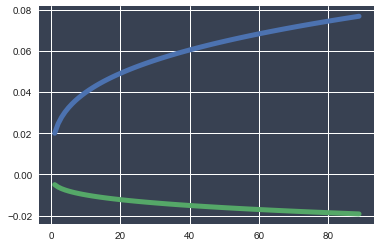

In [578]:
plt.plot(np.arange(1, 90), np.arange(1, 90) ** .3 * .02, linewidth=5)
plt.plot(np.arange(1, 90), np.arange(1, 90) ** .3 * .01 * -1, linewidth=5)

In [ ]:
# environment
class Environment:

    PRICE_IDX = 4  # 종가의 위치

    def __init__(self, chart_data=None, PRICE_IDX=None):
        self.chart_data = chart_data
        self.observation = None
        self.idx = -1
        self.PRICE_IDX = PRICE_IDX

    def reset(self):
        self.observation = None
        self.idx = -1

    def observe(self):
        if len(self.chart_data) > self.idx + 1:
            self.idx += 1
            self.observation = self.chart_data.iloc[self.idx]
            return self.observation
        return None

    def get_price(self):
        if self.observation is not None:
            return self.observation[self.PRICE_IDX]
        return None

    def set_chart_data(self, chart_data):
        self.chart_data = chart_data

# Agent
class Agent:
    # 에이전트 상태가 구성하는 값 개수
    STATE_DIM = 2  # 주식 보유 비율, 포트폴리오 가치 비율

    # 매매 수수료 및 세금
    TRADING_CHARGE = 0  # 거래 수수료 미고려 (일반적으로 0.015%)
    TRADING_TAX = 0  # 거래세 미고려 (실제 0.3%)

    # 행동
    ACTION_BUY = 0  # 매수
    ACTION_SELL = 1  # 매도
    ACTION_HOLD = 2  # 홀딩
#     ACTIONS = [ACTION_BUY, ACTION_SELL]  # 인공 신경망에서 확률을 구할 행동들
#     NUM_ACTIONS = len(ACTIONS)  # 인공 신경망에서 고려할 출력값의 개수
    def __init__(self, environment, 
                 min_trading_unit=1, max_trading_unit=2):
                # Environment 객체
        self.environment = environment  # 현재 주식 가격을 가져오기 위해 환경 참조

        # 최소 매매 단위, 최대 매매 단위, 지연보상 임계치
        self.min_trading_unit = min_trading_unit  # 최소 단일 거래 단위
        self.max_trading_unit = max_trading_unit  # 최대 단일 거래 단위

        # Agent 클래스의 속성
        self.initial_balance = 0  # 초기 자본금
        self.balance = 0  # 현재 현금 잔고
        self.num_stocks = 0  # 보유 주식 수
        self.portfolio_value = 0  # balance + num_stocks * {현재 주식 가격}
#         self.base_portfolio_value = 0  # 직전 학습 시점의 PV
        self.num_buy = 0  # 매수 횟수
        self.num_sell = 0  # 매도 횟수
        self.num_hold = 0  # 홀딩 횟수

        # Agent 클래스의 상태
        self.ratio_hold = 0  # 주식 보유 비율
        self.ratio_portfolio_value = 0  # 포트폴리오 가치 비율
    
    def reset(self):
        self.balance = self.initial_balance
        self.num_stocks = 0
        self.portfolio_value = self.initial_balance
        self.base_portfolio_value = self.initial_balance
        self.num_buy = 0
        self.num_sell = 0
        self.num_hold = 0
        self.ratio_hold = 0
        self.ratio_portfolio_value = 0
        
    def set_balance(self, balance):
        self.initial_balance = balance
        
    def get_states(self): # 필요한 함수인지?
        self.ratio_hold = self.num_stocks / int(
            self.portfolio_value / self.environment.get_price()) ## 필요한 행동인지?
        self.ratio_portfolio_value = self.portfolio_value / self.base_portfolio_value
        return (
            self.ratio_hold,
            self.ratio_portfolio_value
        )
    # action에 대한 값 필요
    def validate_action(self, action):
        validity = True
        if action == Agent.ACTION_BUY:
            # 적어도 1주를 살 수 있는지 확인
            if self.balance < self.environment.get_price() * (
                1 + self.TRADING_CHARGE) * self.min_trading_unit:
                validity = False
        elif action == Agent.ACTION_SELL:
            # 주식 잔고가 있는지 확인
            if self.num_stocks <= 0:
                validity = False
        return validity
    
    def act(self, action, confidence):
        if not self.validate_action(action):
            action = Agent.ACTION_HOLD

        # 환경에서 현재 가격 얻기
        curr_price = self.environment.get_price()

        # 매수
        if action == Agent.ACTION_BUY:
            # 매수할 단위를 판단
            trading_unit = max(min(
                    int(self.balance / (
                        curr_price * (1 + self.TRADING_CHARGE))), self.max_trading_unit),
                    self.min_trading_unit
                )
            # 수수료를 적용하여 총 매수 금액 산정
            invest_amount = curr_price * (1 + self.TRADING_CHARGE) * trading_unit
            self.balance -= invest_amount  # 보유 현금을 갱신
            self.num_stocks += trading_unit  # 보유 주식 수를 갱신
            self.num_buy += 1  # 매수 횟수 증가

        # 매도
        elif action == Agent.ACTION_SELL:
            # 전부 매도하도록 매도 단위 결정
            trading_unit = self.num_stocks #### Change
            # 매도
            invest_amount = curr_price * (
                1 - (self.TRADING_TAX + self.TRADING_CHARGE)) * trading_unit
            self.num_stocks -= trading_unit  # 보유 주식 수를 갱신
            self.balance += invest_amount  # 보유 현금을 갱신
            self.num_sell += 1  # 매도 횟수 증가

        # 홀딩
        elif action == Agent.ACTION_HOLD:
            self.num_hold += 1  # 홀딩 횟수 증가

        # 포트폴리오 가치 갱신
        self.portfolio_value = self.balance + curr_price * self.num_stocks
        profitloss = (
            (self.portfolio_value - self.base_portfolio_value) / self.base_portfolio_value)
        
        self.base_portfolio_value = self.portfolio_value

# Learner
class Learner:
    def __init__(self, stock_code, chart_data, training_data=None,
                 min_trading_unit=1, max_trading_unit=2):
        self.stock_code = stock_code
        self.chart_data = chart_data
        self.training_data = training_data
        self.environment = Environment(chart_data)  # 환경 객체
        # 에이전트 객체
        self.agent = Agent(self.environment,
                           min_trading_unit=min_trading_unit,
                           max_trading_unit=max_trading_unit)
        self.training_data = training_data  # 학습 데이터
        self.sample = None
        self.training_data_idx = -1      
        
    def reset(self):
        self.sample = None
        self.training_data_idx = -1
    
    def fit(self, alg):
        

    def _get_batch(self, memory, batch_size, discount_factor, delayed_reward):
        x = np.zeros((batch_size, 1, self.num_features))
        y = np.full((batch_size, self.agent.NUM_ACTIONS), 0.5)

        for i, (sample, action, reward) in enumerate(
                reversed(memory[-batch_size:])):
            x[i] = np.array(sample).reshape((-1, 1, self.num_features))
            y[i, action] = (delayed_reward + 1) / 2
            if discount_factor > 0:
                y[i, action] *= discount_factor ** i
        return x, y

    def _build_sample(self):
        self.environment.observe()
        if len(self.training_data) > self.training_data_idx + 1:
            self.training_data_idx += 1
            self.sample = self.training_data.iloc[self.training_data_idx].tolist()
            self.sample.extend(self.agent.get_states())
            return self.sample
        return None

    def trade(self, model_path=None, balance=2000000):
        if model_path is None:
            return
        self.policy_network.load_model(model_path=model_path)
        self.fit(balance=balance, num_epoches=1, learning=False)

    

In [130]:
from keras.models import Sequential
from keras.layers import Activation, LSTM, Dense, BatchNormalization
from keras.optimizers import sgd

Using TensorFlow backend.


In [133]:
training_data.shape[1]

15

In [136]:
STATE_DIM = 2
input_dim = training_data.shape[1] + STATE_DIM

ACTION_BUY = 0  # 매수
ACTION_SELL = 1  # 매도
ACTION_HOLD = 2  # 홀딩
ACTIONS = [ACTION_BUY, ACTION_SELL]  # 인공 신경망에서 확률을 구할 행동들
NUM_ACTIONS = len(ACTIONS)
output_dim = NUM_ACTIONS

lr = .01
model = Sequential() 

model.add(LSTM(256, input_shape=(1, input_dim),
                    return_sequences=True, stateful=False, dropout=0.5))
model.add(BatchNormalization())
model.add(LSTM(256, return_sequences=True, stateful=False, dropout=0.5))
model.add(BatchNormalization())
model.add(LSTM(256, return_sequences=False, stateful=False, dropout=0.5))
model.add(BatchNormalization())
model.add(Dense(output_dim))
model.add(Activation('sigmoid'))

model.compile(optimizer=sgd(lr=lr), loss='mse')
prob = None

In [137]:
(1, input_dim) # inpur shape

(1, 17)

In [165]:
for i in range(0, 200):
    sample = training_data.iloc[i].tolist()
    sample.extend(list(np.random.rand(2)))
    print(model.predict(np.array(sample).reshape((1, -1, input_dim)))[0])

[0.49986866 0.4999534 ]
[0.49986604 0.49992317]
[0.49996287 0.49994045]
[0.4999439  0.49976987]
[0.4999619  0.49959937]
[0.4999267  0.49964097]
[0.50001377 0.49977627]
[0.4999848  0.49975574]
[0.49998456 0.49954075]
[0.5000142 0.4996036]
[0.5000386  0.49989006]
[0.4999684  0.49982363]
[0.49998808 0.4997793 ]
[0.49998736 0.49970776]
[0.49998873 0.49985912]
[0.49999    0.49978492]
[0.4999901 0.4999448]
[0.5000201  0.50000787]
[0.49993992 0.50008327]
[0.49990442 0.49969965]
[0.49994516 0.49988863]
[0.49992996 0.4998565 ]
[0.49990985 0.49982423]
[0.49998426 0.49988392]
[0.49989983 0.4997355 ]
[0.49991003 0.49984872]
[0.49997765 0.49991786]
[0.4999311 0.4997689]
[0.49997288 0.49995255]
[0.499951   0.49976885]
[0.49995708 0.49945712]
[0.5000014  0.49971905]
[0.50004536 0.4997256 ]
[0.50003815 0.49962702]
[0.49995905 0.49975026]
[0.50001365 0.4997561 ]
[0.5000103 0.4999061]
[0.50001377 0.49989596]
[0.49998164 0.4997823 ]
[0.49993086 0.49975914]
[0.4999923 0.4998439]
[0.50003487 0.49999452]
[0